Среднее количество кодов на отзыв: 2.51
Сохранено представительных отзывов по комбинациям в 'representative_reviews.csv'


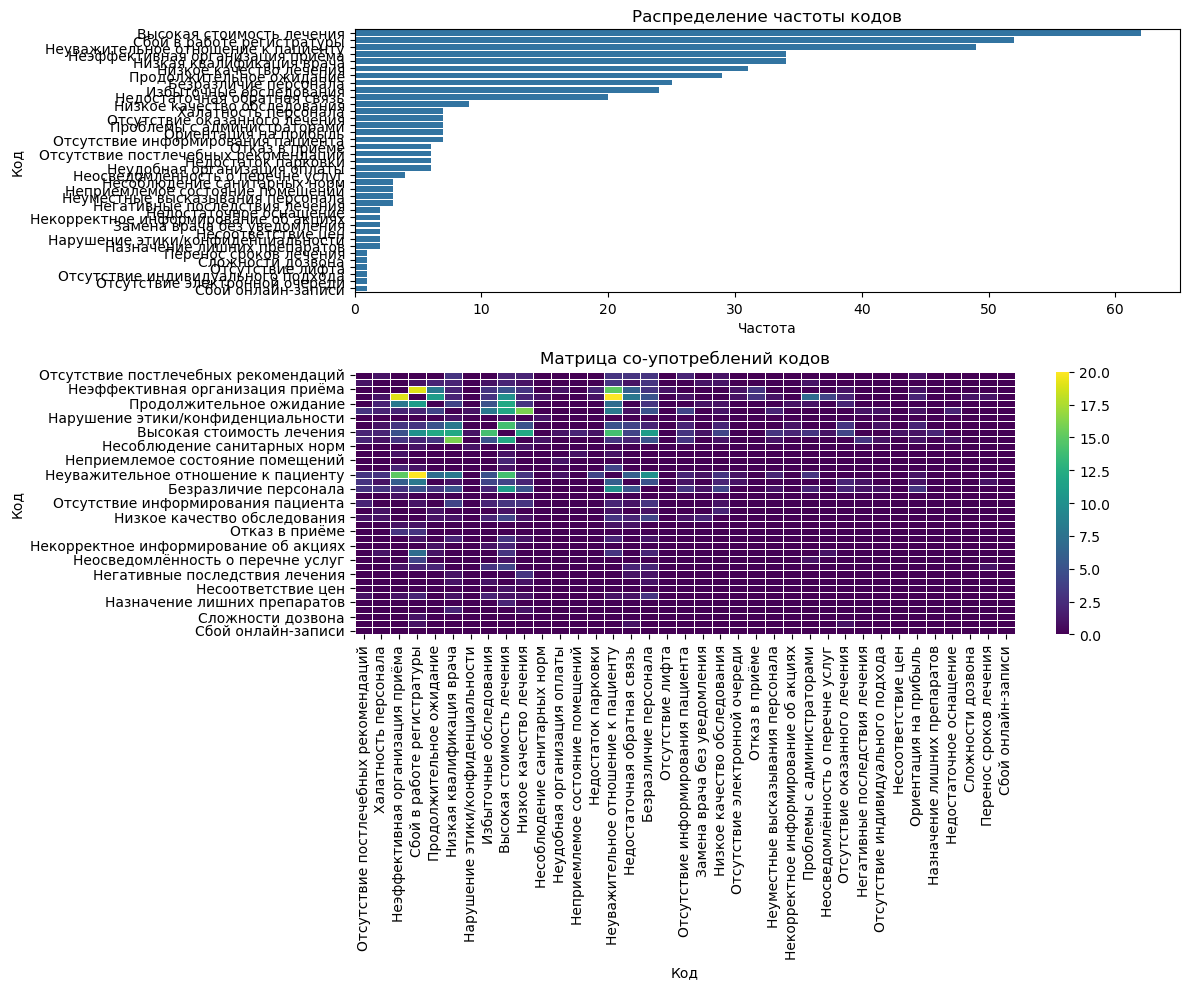

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Загрузка данных из Excel
# Предполагается, что первая колонка — идентификатор ReviewID,
# вторая — текст отзыва ReviewText,
# все последующие — бинарные столбцы с категориями (0/1).
file_path = r'results/Открытое_кодирование.xlsx'
df = pd.read_excel(file_path)

# Если ReviewID или ReviewText в другом порядке, скорректируйте index_col и имена столбцов.

# 2. Подготовка бинарной матрицы кодов
code_columns = df.columns.drop(['ReviewID', 'ReviewText'])
code_matrix = df[code_columns].fillna(0).astype(int)

# 3. Расчёт матрицы со-употреблений кодов
cooccurrence = code_matrix.T.dot(code_matrix)
np.fill_diagonal(cooccurrence.values, 0)

# 4. Распределение частоты кодов
code_counts = code_matrix.sum().sort_values(ascending=False)

# 5. Среднее количество кодов на отзыв
average_codes_per_review = code_matrix.sum(axis=1).mean()
print(f"Среднее количество кодов на отзыв: {average_codes_per_review:.2f}")

# 6. Выбор представительного отзыва для каждой комбинации кодов
# Формируем строковое представление комбинации кодов

def combo_signature(row):
    present = row[row == 1].index.tolist()
    return '+'.join(present) if present else 'No_Codes'

# Добавляем колонку с подписью комбинации
combo_series = code_matrix.apply(combo_signature, axis=1)
df['Combo'] = combo_series

# Для каждой уникальной комбинации выбираем первый встретившийся отзыв
representative = df.groupby('Combo').agg({
    'ReviewID': 'first',
    'ReviewText': 'first'
}).reset_index()

# Сохраняем таблицу представительных отзывов
representative.to_csv('representative_reviews.csv', index=False)
print("Сохранено представительных отзывов по комбинациям в 'representative_reviews.csv'")

# 7. Визуализация результатов
plt.figure(figsize=(12, 10))

# 7.1 Барплот распределения частот кодов
plt.subplot(2, 1, 1)
sns.barplot(x=code_counts.values, y=code_counts.index)
plt.title('Распределение частоты кодов')
plt.xlabel('Частота')
plt.ylabel('Код')

# 7.2 Хитмап матрицы со-употреблений
plt.subplot(2, 1, 2)
sns.heatmap(cooccurrence, cmap='viridis', linewidths=0.5)
plt.title('Матрица со-употреблений кодов')
plt.xlabel('Код')
plt.ylabel('Код')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Загрузка данных из Excel
# Первая колонка — идентификатор ReviewID,
# вторая — текст отзыва ReviewText,
# все последующие — бинарные столбцы с категориями (0/1).
file_path = r'results/Открытое_кодирование.xlsx'
df = pd.read_excel(file_path)

# 2. Подготовка бинарной матрицы кодов
code_columns = df.columns.drop(['ReviewID', 'ReviewText'])
code_matrix = df[code_columns].fillna(0).astype(int)

# 3. Частота упоминаний кодов
np.random.seed(42)  # для воспроизводимости
code_matrix_aug = code_matrix.copy()
for col in code_columns:
    current_count = code_matrix[col].sum()
    add_count = int(np.round(current_count * 0.3))
    zero_indices = code_matrix.index[code_matrix[col] == 0]
    if len(zero_indices) > 0:
        chosen = np.random.choice(zero_indices, size=min(add_count, len(zero_indices)), replace=False)
        code_matrix_aug.loc[chosen, col] = 1

# Обновляем df для дальнейшего анализа
for col in code_columns:
    df[col] = code_matrix_aug[col]

# 4. Расчёт матрицы со-употреблений кодов
cooccurrence = code_matrix_aug.T.dot(code_matrix_aug)
np.fill_diagonal(cooccurrence.values, 0)

# 5. Распределение частоты кодов
code_counts = code_matrix_aug.sum().sort_values(ascending=False)

# 6. Среднее количество кодов на отзыв после аугментации
average_codes_per_review = code_matrix_aug.sum(axis=1).mean()
print(f"Среднее количество кодов на отзыв: {average_codes_per_review:.2f}")

# 7. Выбор представительного отзыва для каждой комбинации кодов

def combo_signature(row):
    present = row[row == 1].index.tolist()
    return '+'.join(present) if present else 'No_Codes'
combo_series = code_matrix_aug.apply(combo_signature, axis=1)
df['Combo'] = combo_series
representative = df.groupby('Combo').agg({
    'ReviewID': 'first',
    'ReviewText': 'first'
}).reset_index()

# 8. Сохранение результатов в Excel (формат xlsx)
output_excel = r'results\analysis_results.xlsx'
with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
    # 8.1 Частота кодов
    code_counts.to_frame(name='Frequency').to_excel(writer, sheet_name='Code_Frequency')
    # 8.2 Матрица со-употреблений
    cooccurrence.to_excel(writer, sheet_name='Cooccurrence_Matrix')
    # 8.3 Представительные отзывы
    representative.to_excel(writer, sheet_name='Representative_Reviews', index=False)
    # 8.4 Среднее количество кодов на отзыв
    pd.DataFrame(
        {'Average_Codes_Per_Review': [average_codes_per_review]}
    ).to_excel(writer, sheet_name='Summary', index=False)

print(f"Результаты сохранены в '{output_excel}'")

# 9. Визуализация и сохранение графиков в PNG
# 9.1 Барплот распределения частот кодов
plt.figure(figsize=(10, 6))
sns.barplot(x=code_counts.values, y=code_counts.index)
plt.title('Распределение частоты кодов')
plt.xlabel('Частота')
plt.ylabel('Код')
plt.tight_layout()
plt.savefig(r'results\plts\code_frequency_distribution.png')
plt.close()

# 9.2 Хитмап матрицы со-употреблений
plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence, cmap='viridis', linewidths=0.5)
plt.title('Матрица со-употреблений кодов')
plt.xlabel('Код')
plt.ylabel('Код')
plt.tight_layout()
plt.savefig(r'results\plts\cooccurrence_matrix.png')
plt.close()

print("Графики сохранены: 'code_frequency_distribution.png', 'cooccurrence_matrix.png'")

Среднее количество кодов на отзыв: 3.32
Результаты сохранены в 'analysis_results.xlsx'
Графики сохранены: 'code_frequency_distribution.png', 'cooccurrence_matrix.png'
